In [14]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score, mean_squared_error,mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import json
#import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
#import pymc3 as pm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import random
#import theano.tensor as tt
#import theano
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import signal
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

In [19]:
df_W = pd.read_csv('new_data_climate_pop_hospitalization_Weekly2.csv')[['state','elderly_mode','school_mode','mask','ILIp','pca_1','date','resid_av7','unweighted_ili','Hospitalization_weeklysum','Hospitalization_weeklyave','Hospitalization_weeklysum_pop']]
df_W['date']=pd.to_datetime(df_W['date'])
#df1_W = df_W[(df_W['date'] >= '2021-09-01')]
df1_W = df_W[(df_W['date'] >= '2020-10-25')]
df1_W = (df1_W.set_index('date',drop=True)).sort_values('state')
states = df1_W['state'].unique()
df1_W.sort_values(['date','state'],inplace=True)
#print(df1_W.head())


df1_W['school_mode'] = df1_W['school_mode'].round().astype('float')
df1_W['elderly_mode'] = df1_W['elderly_mode'].round().astype('float')
mapping = {0: 'no_policy', 1: 'low_policy', 2: 'med_policy', 3: 'high_policy'}
df1_W['elderly_mode'] = df1_W['elderly_mode'].astype(int).map(mapping)
df1_W['school_mode'] = df1_W['school_mode'].astype(int).map(mapping)

#####  ordinal_encoder
ordinal_encoder = OrdinalEncoder(categories=[['no_policy','low_policy','med_policy','high_policy']])
df1_W['school_mode'] = ordinal_encoder.fit_transform(df1_W[['school_mode']])
df1_W['elderly_mode'] = ordinal_encoder.fit_transform(df1_W[['elderly_mode']])

state_dfs_W = []

# List of unique states in your DataFrame
unique_states_W = df1_W['state'].unique()

# pca_1 multiply by negative 1
df1_W['pca_1_multi_negative1'] = df1_W['pca_1']*(-1)
df1_W['Hospitalization_weeklysum_pop_multi_100000'] = df1_W['Hospitalization_weeklysum_pop']*(100000)
#print(df1_W.head())

# Loop through each state
for state in unique_states_W:
    # Filter the data for the current state
    state_df_W = df1_W[df1_W['state'] == state].copy()

    # Apply your operations to the state-specific DataFrame
   # scaler = StandardScaler()
    scaler = MinMaxScaler()
    state_df_W['diff_ilip'] = state_df_W['ILIp'].diff()
    state_df_W['smoothed_ILIp'] = state_df_W['diff_ilip'].rolling(window=7).mean()
    state_df_W['diff_Hospitalization_weeklyave'] = state_df_W['Hospitalization_weeklyave'].diff()
    state_df_W['smoothed_Hospitalization_weeklyave'] = state_df_W['diff_Hospitalization_weeklyave'].rolling(window=7).mean()
    state_df_W['diff_Hospitalization_weeklysum'] = state_df_W['Hospitalization_weeklysum'].diff()
    state_df_W['smoothed_Hospitalization_weeklysum'] = state_df_W['diff_Hospitalization_weeklysum'].rolling(window=7).mean()
    state_df_W['diff_Hospitalization_weeklysum_pop_multi_100000'] = state_df_W['Hospitalization_weeklysum_pop_multi_100000'].diff()
    state_df_W = state_df_W.dropna()
    state_df_W['school_mode_lag'] = state_df_W['school_mode'].shift(1)
    state_df_W['elderly_mode_lag'] = state_df_W['elderly_mode'].shift(1)
    state_df_W['school_mode_lag_temp'] = state_df_W['school_mode_lag']
    state_df_W['elderly_mode_lag_temp'] = state_df_W['elderly_mode_lag']
    #state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili','Hospitalization_weeklyave','Hospitalization_weeklysum']] = scaler.fit_transform(state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili','Hospitalization_weeklyave','Hospitalization_weeklysum']])
    state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili','Hospitalization_weeklyave','Hospitalization_weeklysum','Hospitalization_weeklysum_pop_multi_100000', 'Hospitalization_weeklysum_pop']] = scaler.fit_transform(state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili','Hospitalization_weeklyave','Hospitalization_weeklysum','Hospitalization_weeklysum_pop_multi_100000','Hospitalization_weeklysum_pop']])
    #state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili']] = scaler.fit_transform(state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili']])
    # state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili']] = scaler.fit_transform(state_df_W[['mask','pca_1','pca_1_multi_negative1','ILIp','resid_av7','unweighted_ili']])
    state_df_W['ILIp_lag'] = state_df_W['ILIp'].shift(1)
    state_df_W['Hospitalization_weeklyave_lag'] = state_df_W['Hospitalization_weeklyave'].shift(1)
    state_df_W['Hospitalization_weeklysum_lag'] = state_df_W['Hospitalization_weeklysum'].shift(1)
    state_df_W['Hospitalization_weeklysum_pop_multi_100000_lag'] = state_df_W['Hospitalization_weeklysum_pop_multi_100000'].shift(1)
    state_df_W['Hospitalization_weeklysum_pop_lag'] = state_df_W['Hospitalization_weeklysum_pop'].shift(1)
    state_df_W['diff_Hospitalization_weeklyave_lag'] = state_df_W['diff_Hospitalization_weeklyave'].shift(1)
    state_df_W['diff_Hospitalization_weeklysum_lag'] = state_df_W['diff_Hospitalization_weeklysum'].shift(1)
    state_df_W.sort_values(['state','date'], inplace=True, ascending=True)
    state_df_W = pd.get_dummies(state_df_W, columns=['school_mode_lag'], prefix='school_mode')
    state_df_W = pd.get_dummies(state_df_W, columns=['elderly_mode_lag'], prefix='elderly_mode')
    state_df_W['mask_lag'] = state_df_W['mask'].shift(1)
    state_df_W['resid_av7_lag'] = state_df_W['resid_av7'].shift(4)
    state_df_W['pca_1_lag'] = state_df_W['pca_1'].shift(4)
    state_df_W['pca_1_multi_negative1_lag'] = state_df_W['pca_1_multi_negative1'].shift(4)

    
  #  state_df_W = state_df_W[:'2022-06-26'].dropna()
    state_df_W = state_df_W.dropna()
    
    # Append the state-specific DataFrame to the combined DataFrame
    state_dfs_W.append(state_df_W)
   

# Print the shape of the combined DataFrame and display the first few rows
combined_df_W = pd.concat(state_dfs_W[:])
combined_df1_W=combined_df_W.sort_values(['date','state'])
#state_mapping = {state: index for index, state in enumerate(unique_states, start=1)}
#combined_df1['state'] = combined_df1['state'].map(state_mapping)
combined_df1_W.head()

#print(combined_df1_W['school_mode_lag_temp'].tolist())
    



,state,elderly_mode,school_mode,mask,ILIp,pca_1,resid_av7,unweighted_ili,Hospitalization_weeklysum,Hospitalization_weeklyave,...,school_mode_2.0,school_mode_3.0,elderly_mode_1.0,elderly_mode_2.0,mask_lag,resid_av7_lag,pca_1_lag,pca_1_multi_negative1_lag,school_mode_0.0,elderly_mode_3.0
date,,,,,,,,,,,,,,,,,,,,,
2021-01-10,AL,2.0,2.0,0.988297,0.302062,0.214578,0.642857,0.096335,0.642857,0.642857,...,True,NaN,False,True,0.983057,0.464286,0.372837,0.627163,False,NaN
2021-01-10,AR,3.0,2.0,0.966400,0.000000,0.514263,0.344828,0.164860,0.292135,0.292135,...,True,NaN,False,False,0.961833,0.310345,0.571727,0.428273,False,True
2021-01-10,CO,2.0,2.0,0.982012,0.000000,0.089255,0.768421,0.004682,0.000000,0.000000,...,True,NaN,NaN,True,0.983475,0.863158,0.090026,0.909974,NaN,NaN
2021-01-10,DE,3.0,2.0,0.991881,0.013750,0.222116,0.720930,0.187744,0.000000,0.000000,...,True,NaN,False,False,0.981206,0.662791,0.308284,0.691716,NaN,True
2021-01-10,ID,2.0,2.0,0.978183,0.011284,0.138654,0.654321,0.066321,0.095238,0.095238,...,True,NaN,False,True,0.983011,0.641975,0.205546,0.794454,False,NaN


In [21]:
#formula = "Hospitalization_weeklyave ~ Hospitalization_weeklyave_lag + C(school_mode_lag_temp) + mask_lag + pca_1_lag + C(elderly_mode_lag_temp) "
#formula = "Hospitalization_weeklyave ~ Hospitalization_weeklyave_lag+  C(school_mode_lag_temp)  + mask_lag + pca_1_multi_negative1_lag + C(elderly_mode_lag_temp) "
#formula = "Hospitalization_weeklysum_pop_multi_100000 ~ Hospitalization_weeklysum_pop_multi_100000_lag+  C(school_mode_lag_temp)  + mask_lag + pca_1_multi_negative1_lag + C(elderly_mode_lag_temp) "
#formula = "Hospitalization_weeklysum_pop ~ Hospitalization_weeklysum_pop_lag+  C(school_mode_lag_temp)  + mask_lag + pca_1_multi_negative1_lag + C(elderly_mode_lag_temp) "
formula = "Hospitalization_weeklysum ~ Hospitalization_weeklysum_lag+  C(school_mode_lag_temp)  + mask_lag + pca_1_multi_negative1_lag + C(elderly_mode_lag_temp) "

model = smf.mixedlm(formula, data=combined_df1_W,groups=combined_df1_W['state'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:             MixedLM  Dependent Variable:  Hospitalization_weeklysum
No. Observations:  3709     Method:              REML                     
No. Groups:        50       Scale:               0.0148                   
Min. group size:   28       Log-Likelihood:      2492.1912                
Max. group size:   77       Converged:           Yes                      
Mean group size:   74.2                                                   
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.048    0.008  6.402 0.000  0.033  0.063
C(school_mode_lag_temp)[T.1.0]  -0.004    0.006 -0.639 0.523 -0.016  0.008
C(school_mode_lag_temp)[T.2.0]  -0.019    0.008 -2.332 0.020 -0.036 -0.003
C(school_mode_lag_temp)[T.3.0]  -0.043    0.022 -1.964 0.050 -0.085 -0.000
C(elderly_mode_lag_temp)[T.2.0]  0.000    0.005  0.085 0.932 -0.010  0.011
C(elderly_mode_lag_temp)[T.3.0] -0.009    0.012 -0.737 0.461 -0.033  0.015
Hospitalization_weeklysum_lag    0.784    0.011 72.512 0.000  0.763  0.806
mask_lag                        -0.103    0.011 -9.441 0.000 -0.124 -0.082
pca_1_multi_negative1_lag        0.120    0.013  9.297 0.000  0.095  0.146
Group Var                        0.000    0.001                           
==========================================================================

"""

In [22]:
#formula2 = "Hospitalization_weeklyave ~ Hospitalization_weeklyave_lag"
formula2 = "Hospitalization_weeklysum ~ Hospitalization_weeklysum_lag"
model2 = smf.mixedlm(formula2, data=combined_df1_W,groups=combined_df1_W['state'])
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: Hospitalization_weeklysum
No. Observations: 3709    Method:             REML                     
No. Groups:       50      Scale:              0.0158                   
Min. group size:  28      Log-Likelihood:     2421.5485                
Max. group size:  77      Converged:          Yes                      
Mean group size:  74.2                                                 
------------------------------------------------------------------------
                               Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                      0.015                                    
Hospitalization_weeklysum_lag  0.844                                    
Group Var                      0.000                                    
=======================================================================

"""

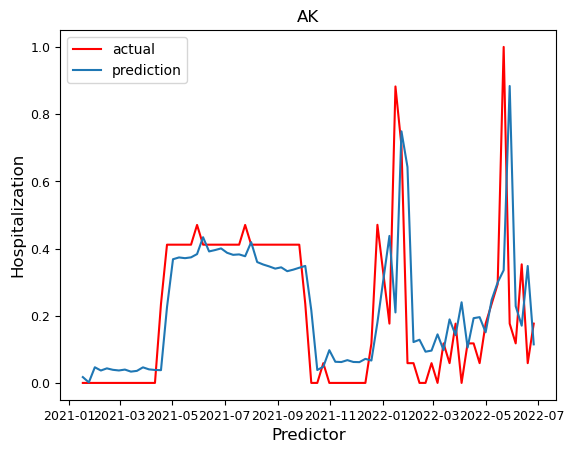

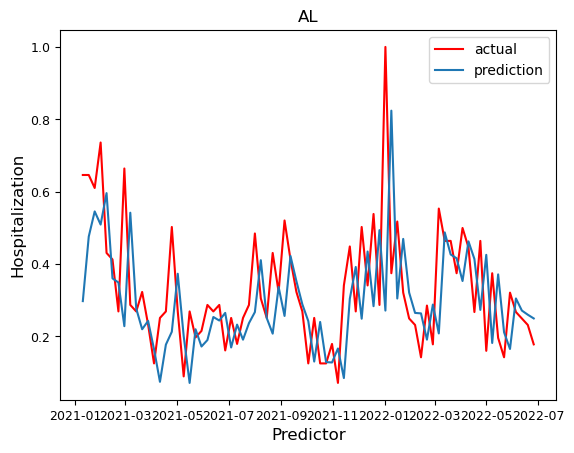

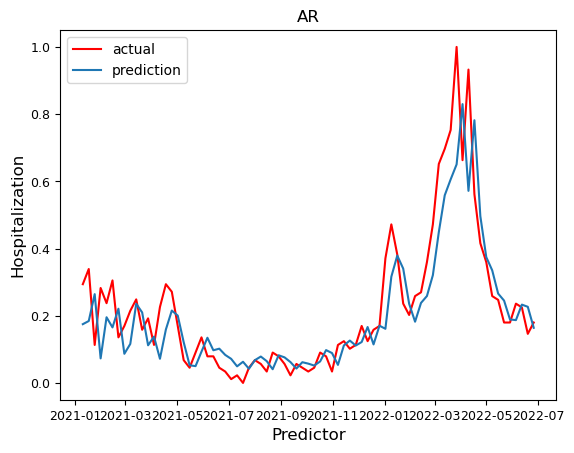

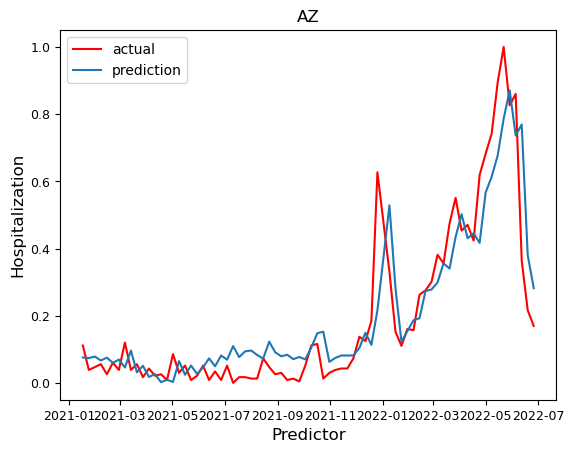

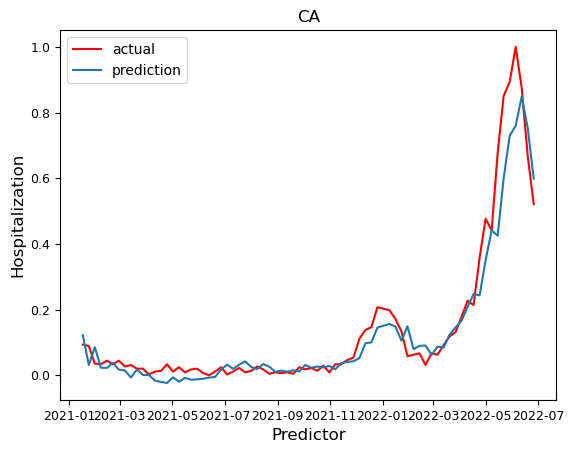

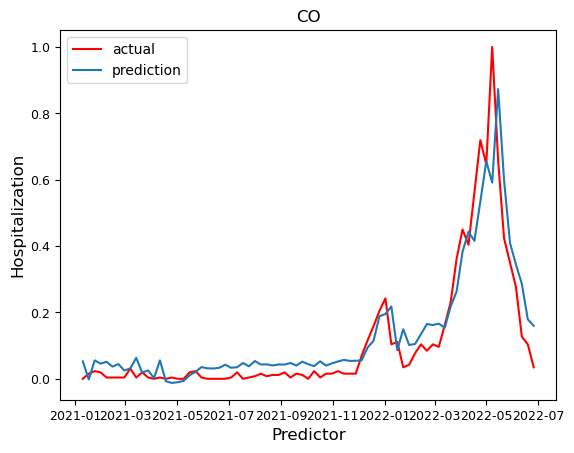

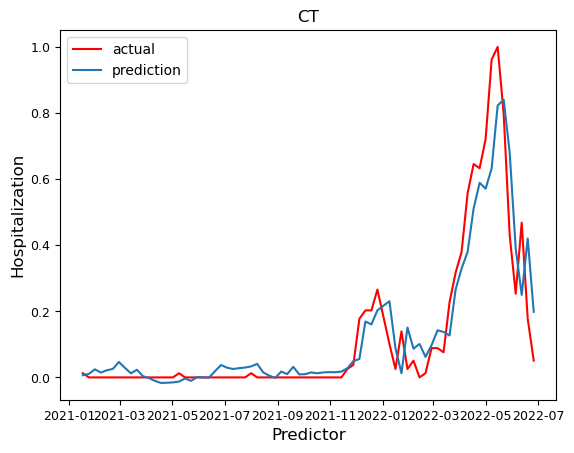

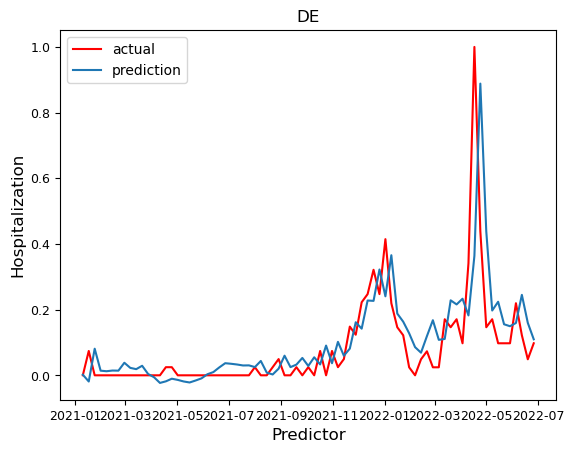

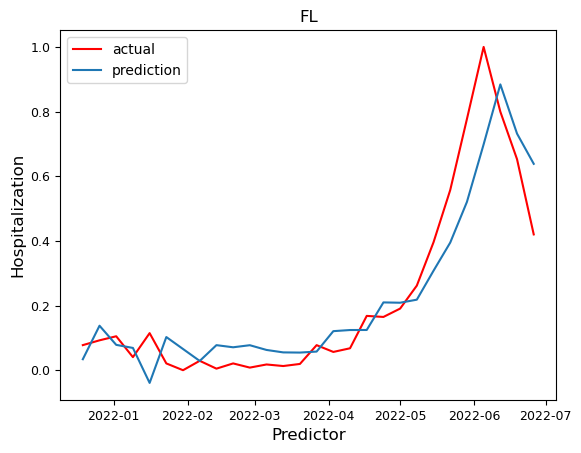

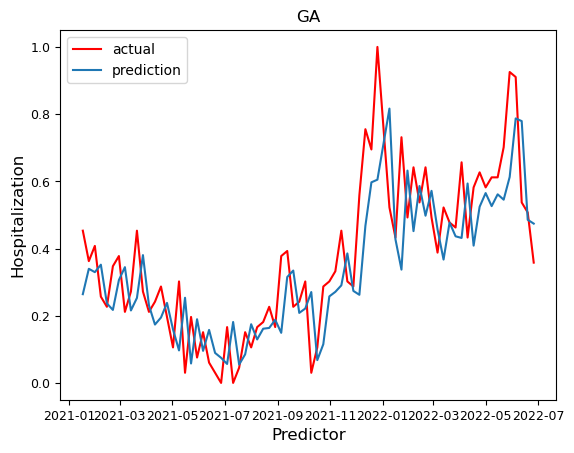

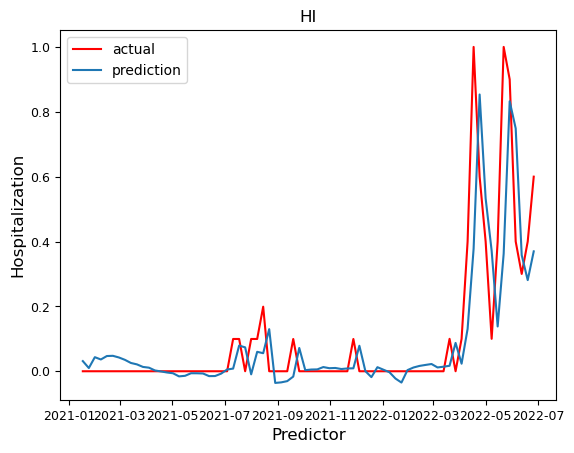

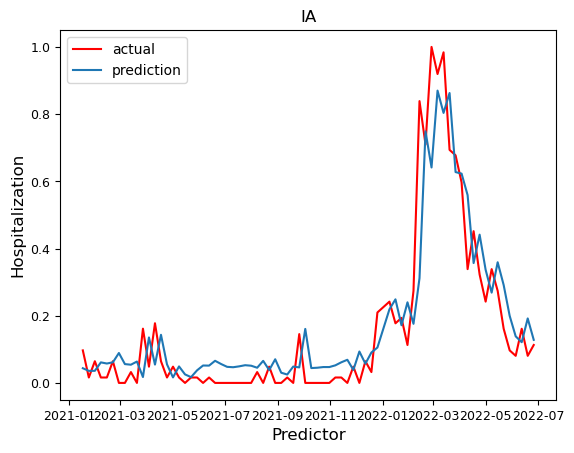

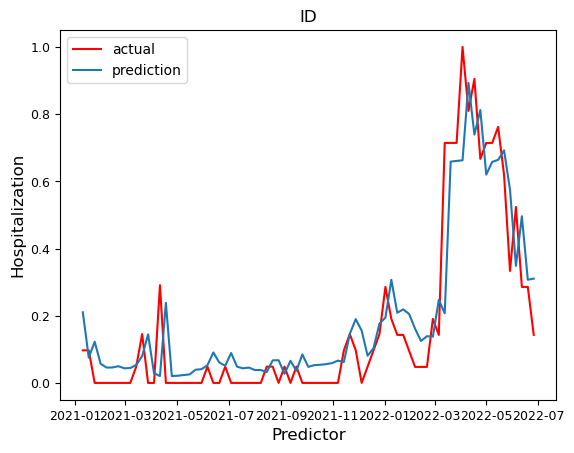

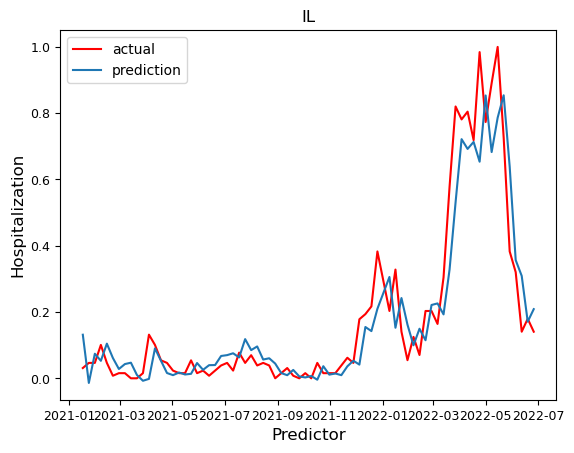

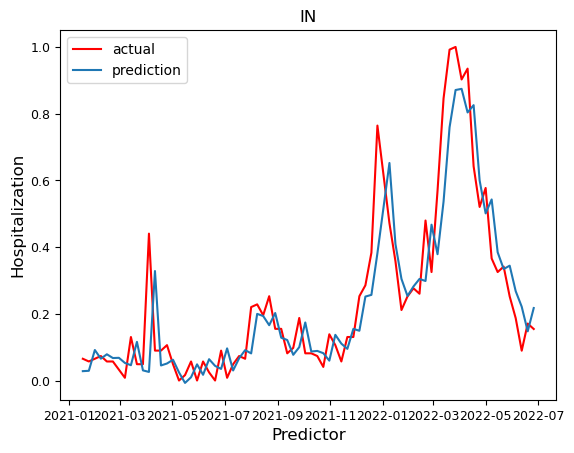

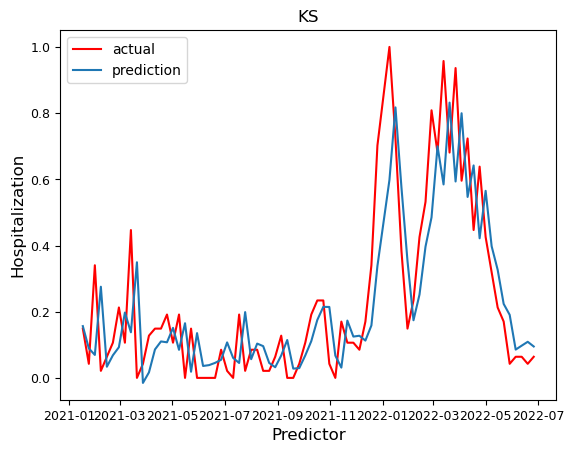

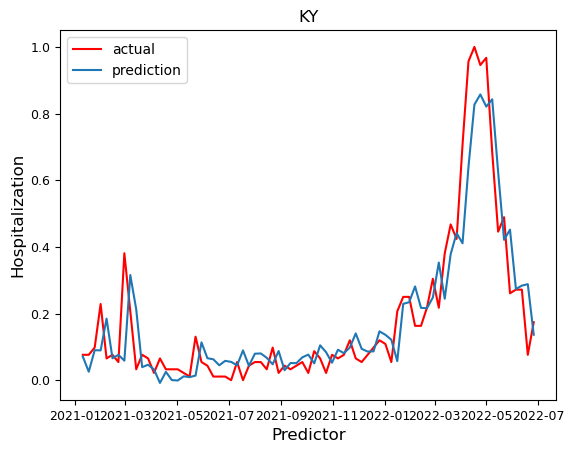

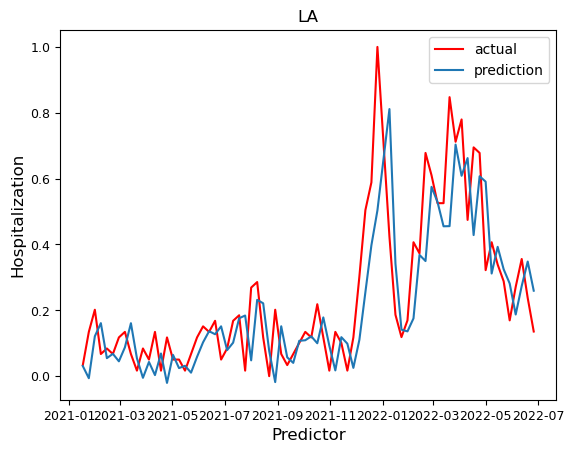

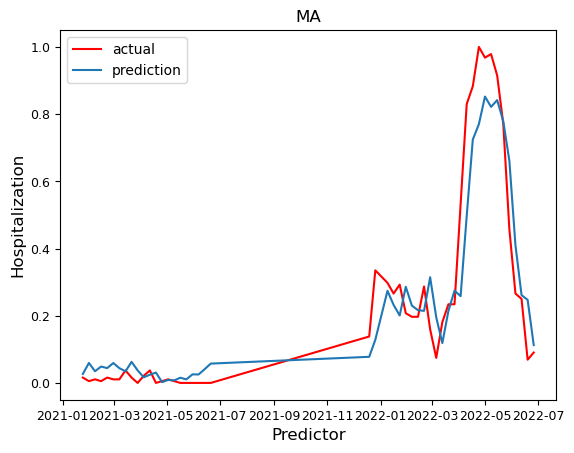

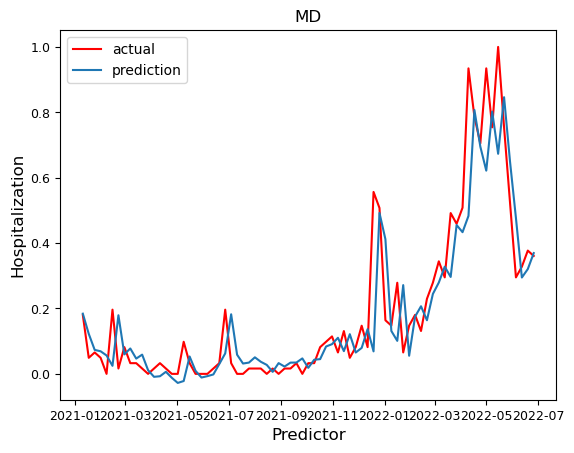

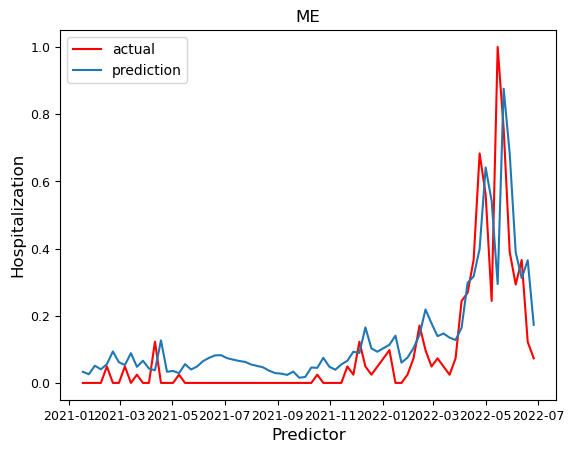

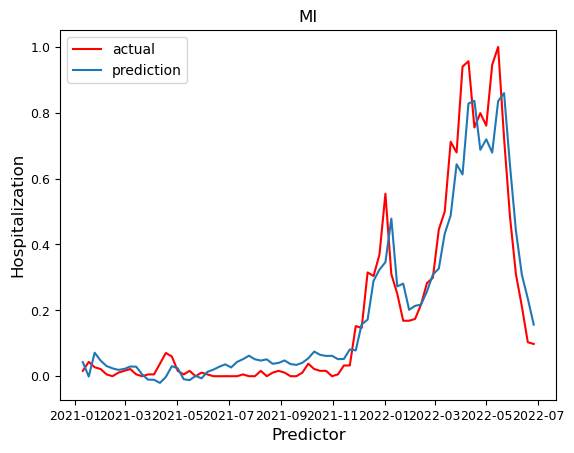

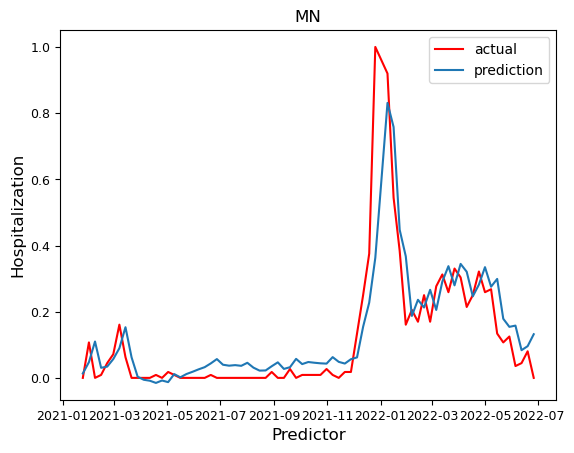

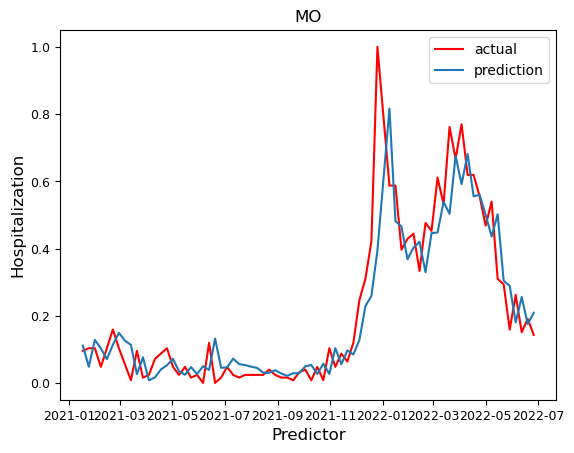

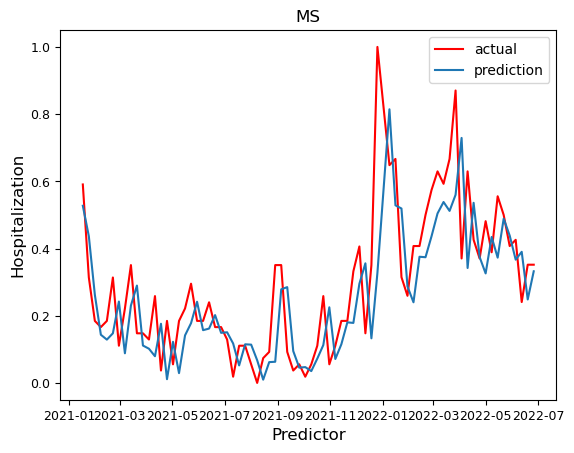

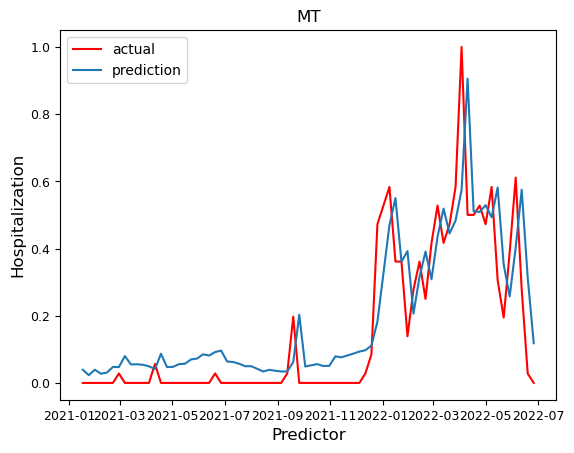

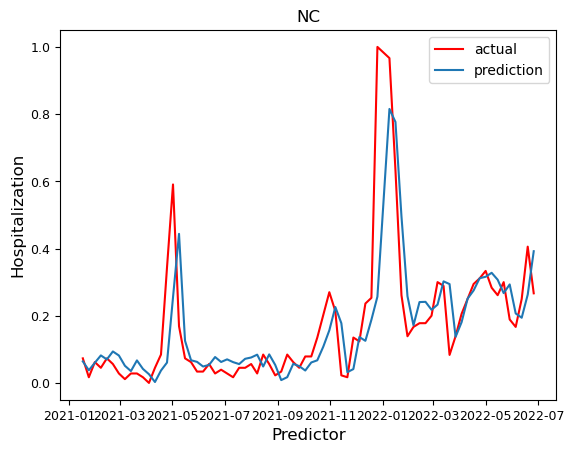

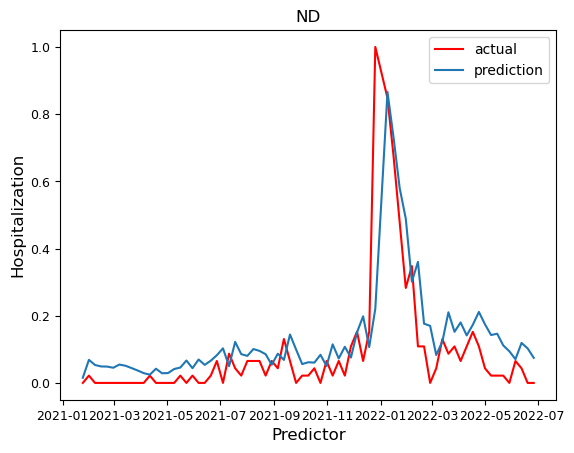

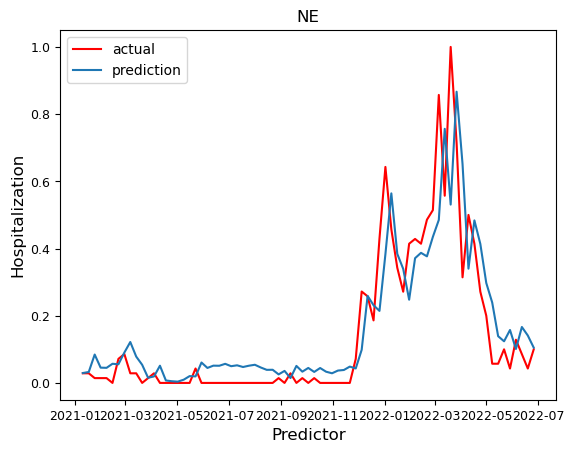

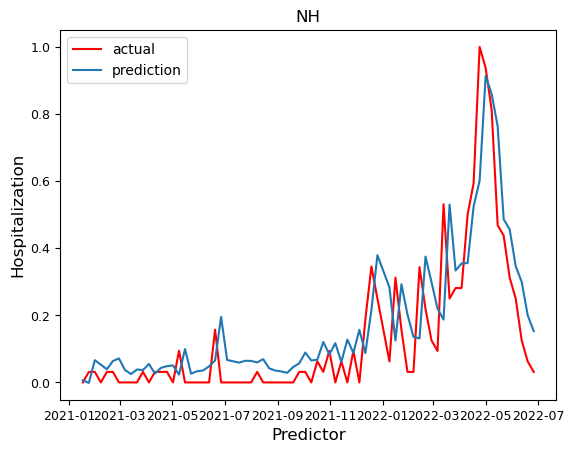

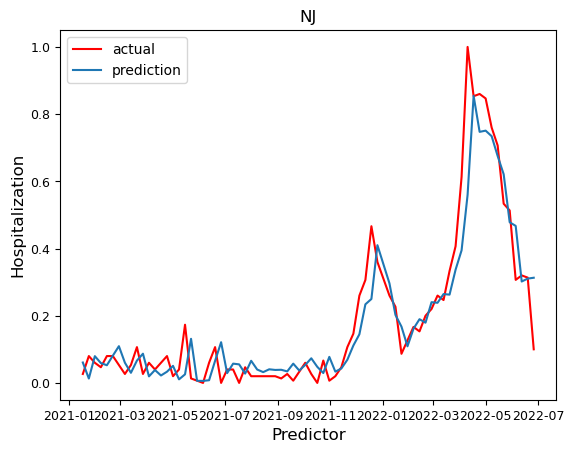

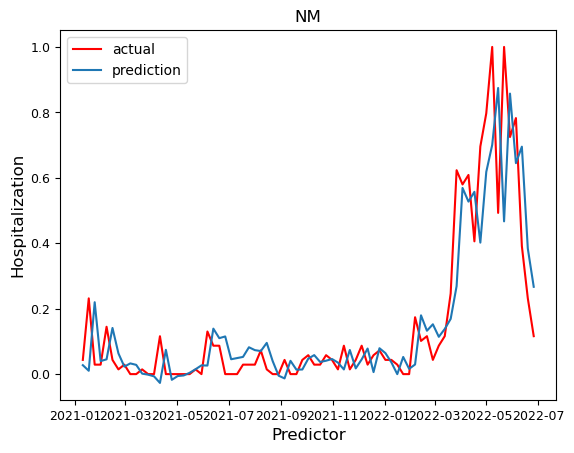

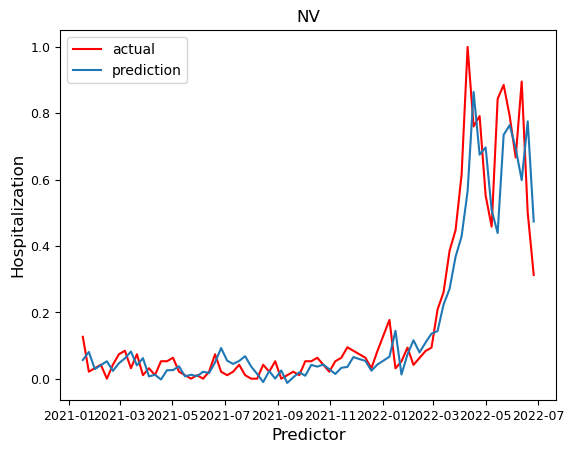

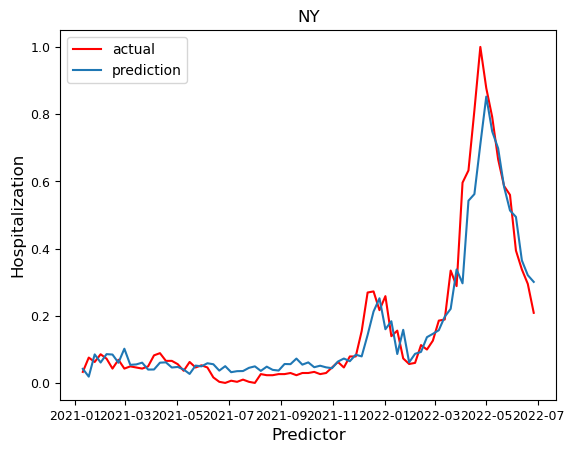

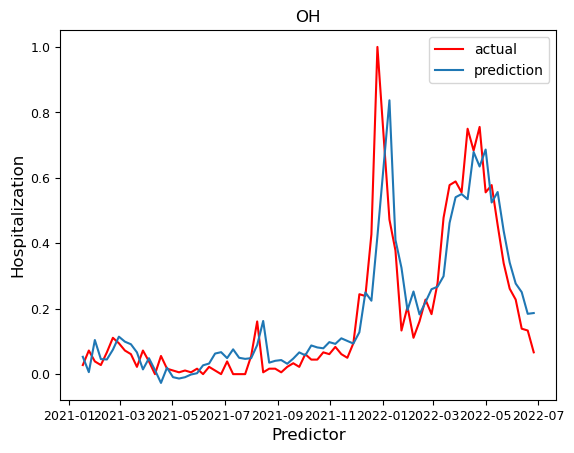

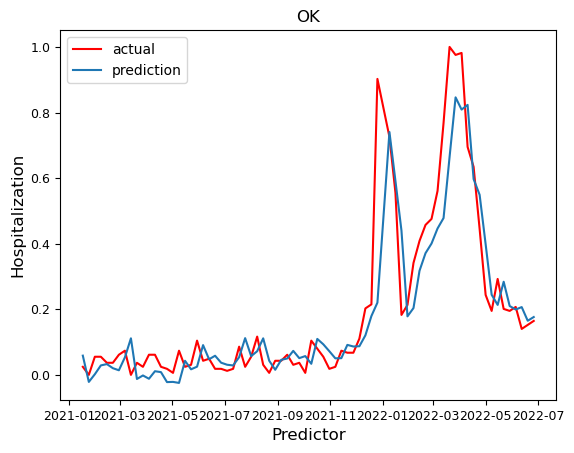

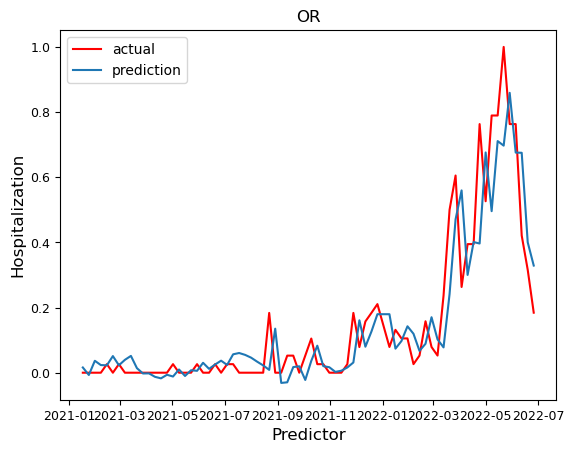

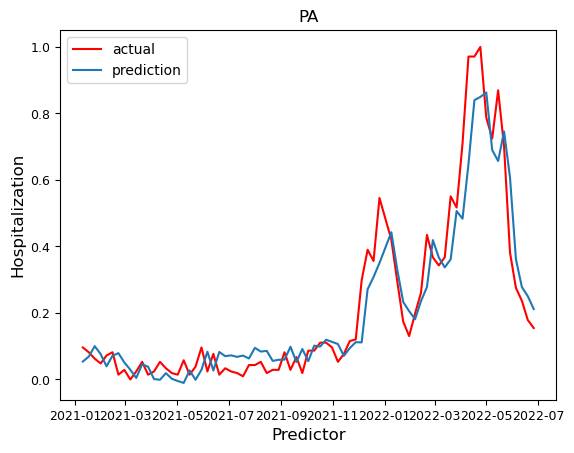

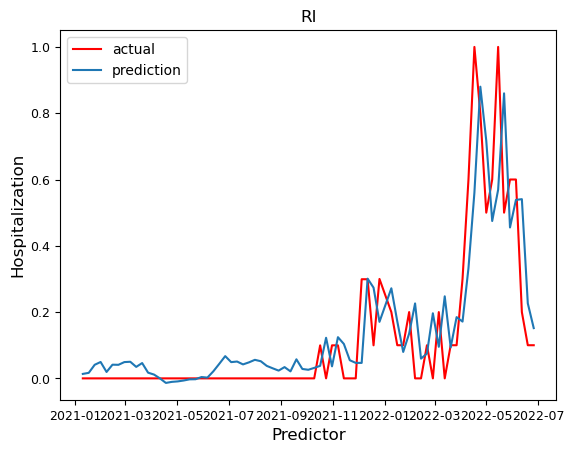

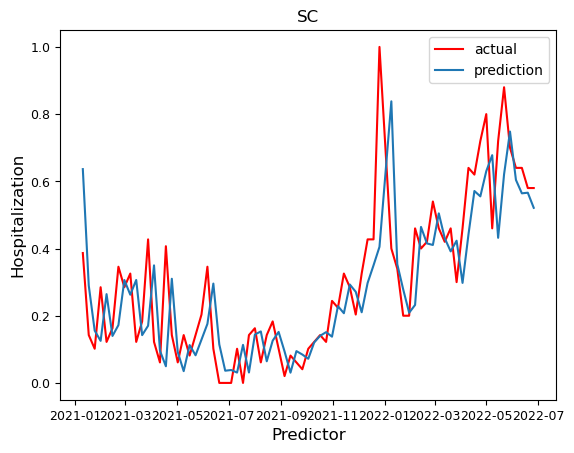

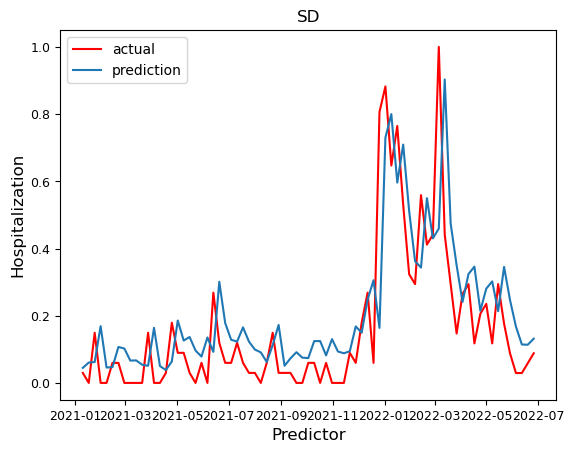

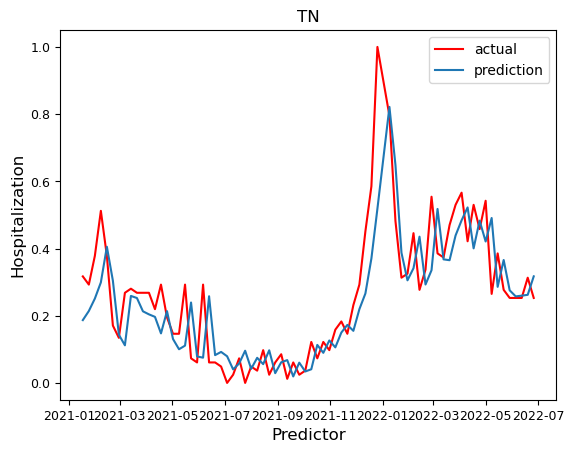

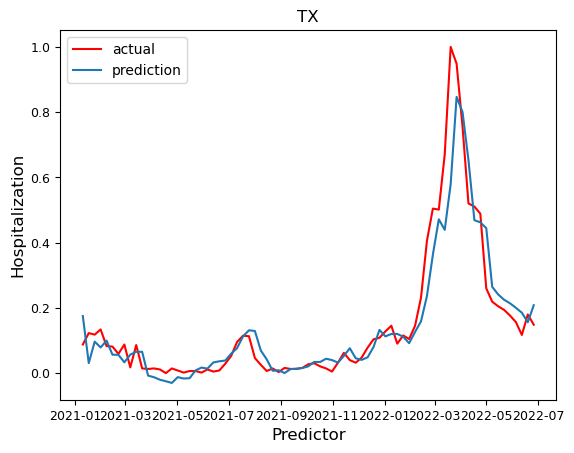

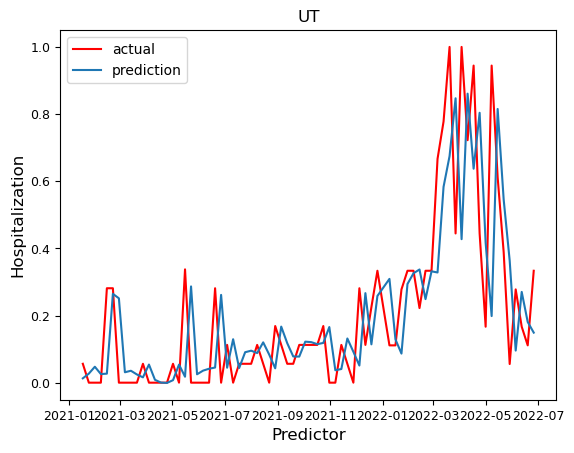

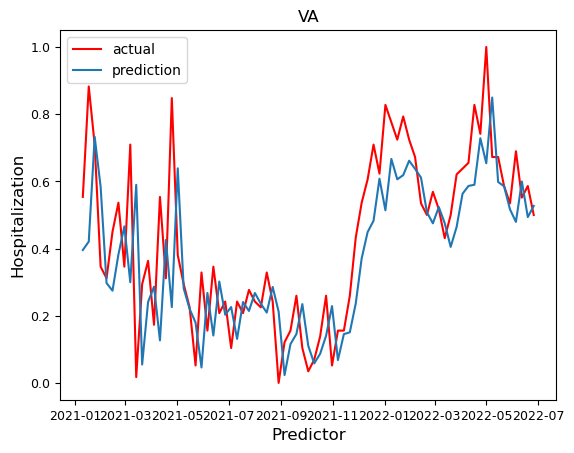

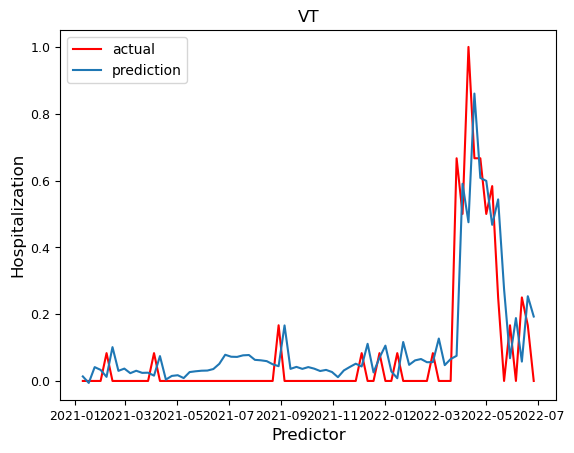

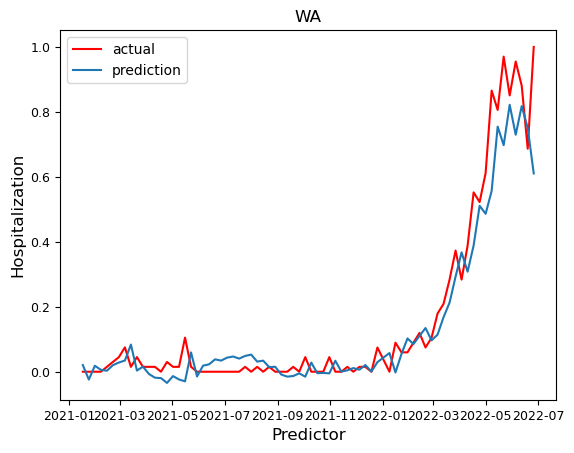

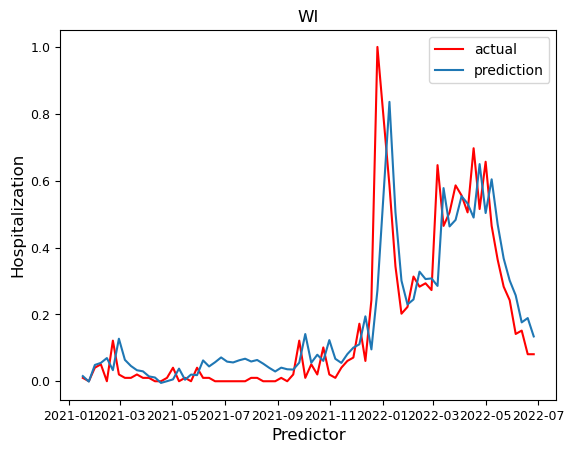

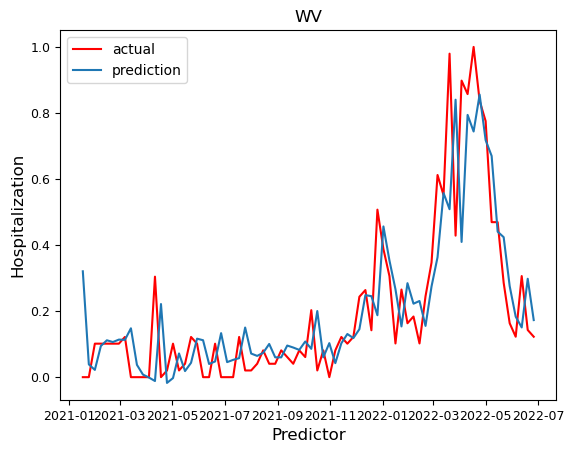

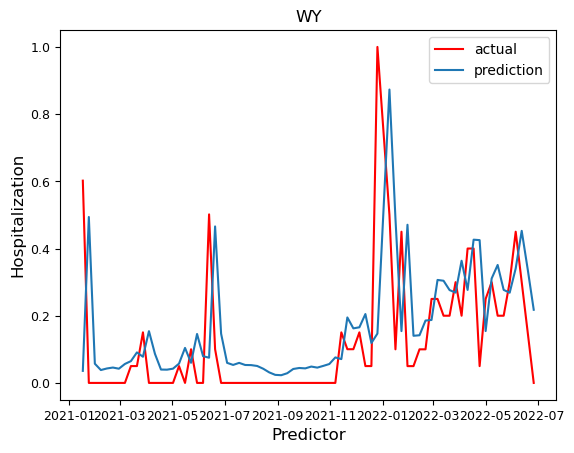

In [23]:
import matplotlib.ticker as ticker

r2_scores_W = []

# Group your data by 'state' and get predictions and R-squared scores for each group
groups_W = combined_df1_W.groupby('state')
for group_name_W, group_data_W in groups_W:
    # Get predicted values for this group
    predicted_values_group_W = result.predict(group_data_W)
    no_predictor_value_group = result2.predict(group_data_W)
    
  #  Hospitalization_Predictor = group_data_W['Hospitalization_weeklysum_lag'] 
  #  Hospitalization_Predictor = group_data_W['mask'] 
    
    # Calculate R-squared for this group
    #date_group_W = group_data_W['date'] 
 #   actual_values_group_W = group_data_W['Hospitalization_weeklyave'] 
  #  actual_values_group_W = group_data_W['Hospitalization_weeklysum_pop_multi_100000'] 
    actual_values_group_W = group_data_W['Hospitalization_weeklysum_pop']
  #  actual_values_group_W = group_data_W['Hospitalization_weeklysum']
    r_squared_group_W = r2_score(actual_values_group_W, predicted_values_group_W)
#    fig, ax = plt.subplots()
    plt.plot(actual_values_group_W,color='red',label='actual')
    plt.plot(predicted_values_group_W,label='prediction')
   # plt.plot(no_predictor_value_group, color='black',label='no_predictor')
   # plt.scatter(Hospitalization_Predictor, actual_values_group_W - predicted_values_group_W, color='black',label='Residual') # residual
   # plt.scatter(Hospitalization_Predictor, actual_values_group_W - no_predictor_value_group, color='red',label='Residual_Nopredictor') # residual
    plt.xlabel("Predictor", fontsize=12)
   # plt.ylabel("Hospitalization Residual", fontsize=12)
    plt.ylabel("Hospitalization", fontsize=12)
    plt.legend()
    plt.title(group_name_W, fontsize=12)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.savefig(group_name_W)


#    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=95))

    plt.show()
    # Store the R-squared score in the list along with the group name
    r2_scores_W.append((group_name_W, r_squared_group_W))


In [24]:
#random_effects_W = result.random_effects
r_squared_valuesW = [score for _, score in r2_scores_W]
mean_r2_score_W = sum(r_squared_valuesW) / len(r_squared_valuesW)
mean_r2_score_W

0.684078202985879